C:\Users\samcm\AppData\Local\Temp\ipykernel_16160\695186361.py:3: DeprecationWarning: Please use `pearsonr` from the `scipy.stats` namespace, the `scipy.stats.stats` namespace is deprecated.
  from scipy.stats.stats import pearsonr


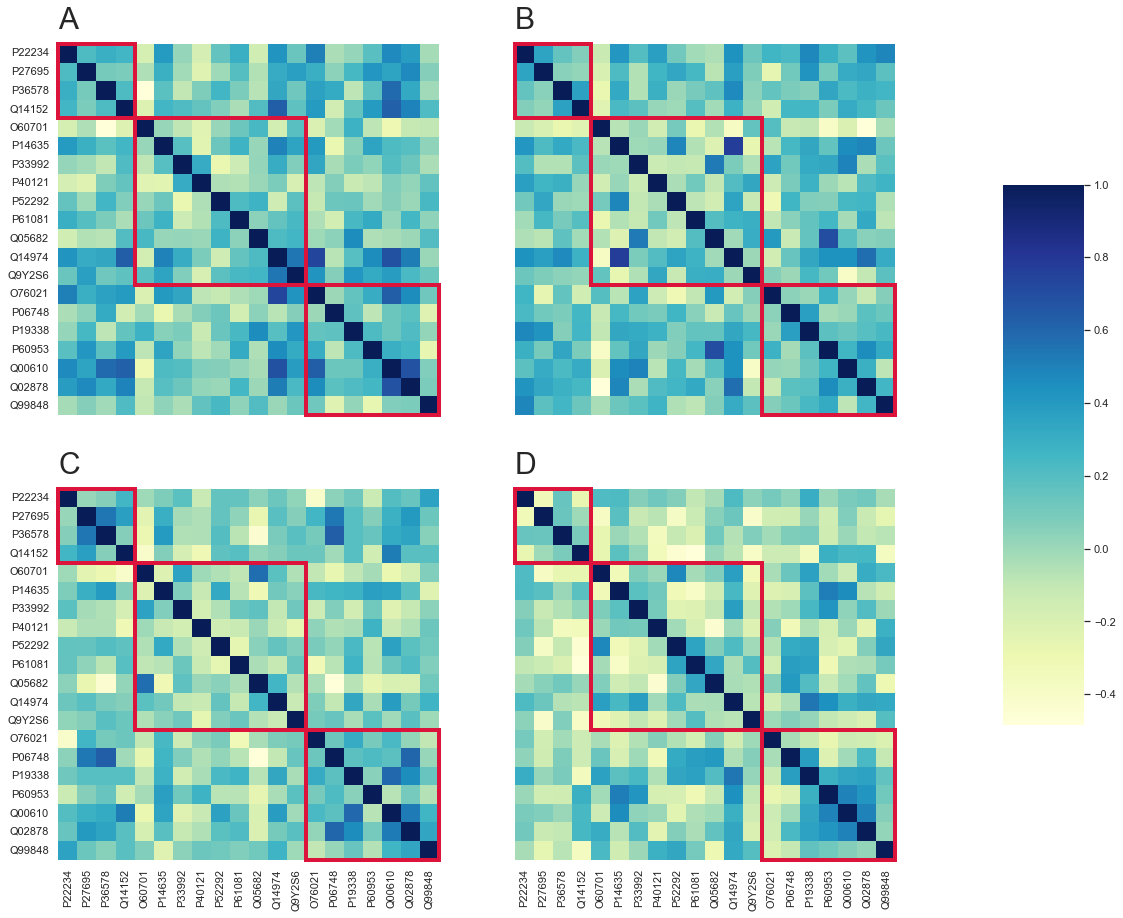

In [4]:
import pandas as pd
import numpy as np
from scipy.stats.stats import pearsonr
import itertools
from matplotlib.patches import Rectangle
import matplotlib.pyplot as plt
import seaborn as sns; sns.set_theme()
from numpy import genfromtxt


df = pd.read_csv("USETHISSAMMARKERSONLY.csv")
df = df.drop(["Sample", "File.ID", "Creation.Date"], axis = 1)

left_side = df.loc[df['Side'] == "Left"]
left_red = left_side.loc[left_side['Chip'] == "_RedChip_"]
left_qc = left_side.loc[left_side['Chip'] == "_QCChip_"]

left_red = left_red.drop(["Chip", "Side"], axis = 1)
left_qc = left_qc.drop(["Chip", "Side"], axis = 1)

right_side = df.loc[df['Side'] == "Right"]
right_red = right_side.loc[right_side['Chip'] == "_RedChip_"]
right_qc = right_side.loc[right_side['Chip'] == "_QCChip_"]

right_red = right_red.drop(["Chip", "Side"], axis = 1)
right_qc = right_qc.drop(["Chip", "Side"], axis = 1)

all_dfs = [left_red, right_red, left_qc, right_qc]

sub, axes = plt.subplots(2, 2, sharex=True, sharey=True, figsize=(15,15))
cbar_ax = sub.add_axes([1, .25, .075, .5])

list_of_dfs = []

for data in all_dfs:
    data = data.fillna(0)
    proteins = data.columns

    correlations = {}
    columns = data.columns.tolist()

    for col_a, col_b in itertools.combinations(columns, 2):
        correlations[col_a + '__' + col_b] = pearsonr(data.loc[:, col_a], data.loc[:, col_b])

    result = pd.DataFrame.from_dict(correlations, orient='index')
    result.columns = ['PCC', 'p-value']

    pd.reset_option('^display.', silent=True)

    num = len(proteins) # Number of markers

    proteins_array = np.zeros([num, num], dtype='float')

    line = 0
    j = 0

    for i in range(0, len(result)):
        proteins_array[line][j + line + 1] = result["PCC"][i]
        proteins_array[j + line + 1][line] = result["PCC"][i]
        j += 1
        if j + line == num - 1:
            line += 1
            j = 0

    maxVals = []
    indexes = []
    pairs = []
    for i in range(0, len(proteins_array)):
        maxVals.append(max(proteins_array[i]))
        indexes.append(np.where(proteins_array[i] == maxVals[-1])[0][0])
        pairs.append([maxVals[-1], proteins[indexes[-1]]])

    phases = pd.read_csv('phase_markers_excluded.csv')

    gene_list = phases.loc[:,"Accession"]

    phase_list = phases.loc[:,"Phase"]

    phase_dict = dict(zip(gene_list, phase_list))

    for i in range(0, len(pairs)):
        pairs[i].append(phase_dict[proteins[i]])
        pairs[i].append(phase_dict[pairs[i][1]])


    max_df = pd.DataFrame(pairs, columns = ["MaxVal", "Protein", "Row Phase", "Associated Phase"], index = proteins)
    max_df = max_df.sort_values(by=["Row Phase"])
    import matplotlib.pyplot as plt

    for i in range(0, len(proteins)):
        proteins_array[i][i] = 1

    proteins_df = pd.DataFrame(proteins_array, columns = proteins, index = proteins)
    list_of_dfs.append(proteins_df)

sub_plot_char = "A"
for i, axn in enumerate(axes.flat):
    temp_map = sns.heatmap(list_of_dfs[i], cmap="YlGnBu", ax=axn, cbar=i == 0,  cbar_ax= cbar_ax)

    temp_map.set_title(chr(ord(sub_plot_char) + i), fontsize = 30, loc = "left", pad = 15)
    phases_list = ["G1", "G2", "M"]
    x_shift = 0
    for phase in phases_list:
        temp = phases.loc[phases['Phase'] == phase]
        num = temp.shape[0]
        temp_map.add_patch(Rectangle((x_shift,x_shift),num,num, fill = False, edgecolor="crimson", lw=4, clip_on=False))
        x_shift += num